In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [5]:
path = '/Users/pranithreddysankepally/Downloads/lfw3'

In [57]:
transform    = transforms.Compose([transforms.Resize((250, 250)),transforms.ToTensor()
                                   ]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [58]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


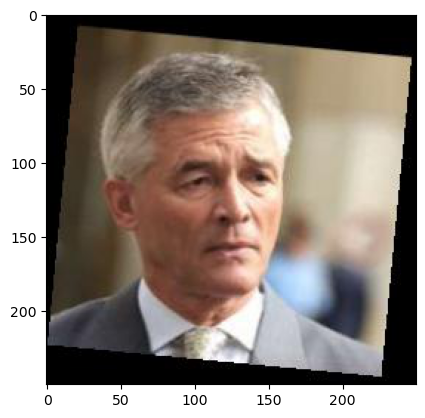

In [59]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

# The main differences between Autoencoders and Variational Autoencoders (VAEs):

# Applications

# Autoencoders:

Dimensionality Reduction: Similar to PCA but nonlinear, autoencoders are often used for reducing the dimensions of data.

Feature Learning: They can learn efficient codings of the input data, which can be useful in pretraining for other tasks.

Denoising: Autoencoders can be used to remove noise from images or signals.

Anomaly Detection: By learning to recreate normal data, they can identify anomalies based on poor reconstruction.

# Variational Autoencoders:

Generative Modeling: VAEs are generative models, meaning they can generate new data instances that resemble the training data.

Image Generation and Editing: They can create realistic images or modify existing ones (e.g., altering facial features).

Semi-Supervised Learning: Leveraging their generative properties, VAEs can be useful in scenarios with limited labeled data.

Interpolation in Latent Space: They can smoothly interpolate between different data points, useful in applications like style transfer.


# Architecture

# Autoencoders:

Encoder-Decoder Structure: Comprises an encoder that compresses the input into a latent representation and a decoder that reconstructs the input from this representation.

Deterministic: The latent representation is a deterministic function of the input.

# Variational Autoencoders:

Probabilistic Encoder and Decoder: The encoder in a VAE maps inputs into a distribution over the latent space, typically Gaussian.

Reparameterization Trick: Introduces a randomness in the encoding process, allowing the model to generate different outputs.

Sampling from Latent Space: The decoder samples from the latent space distribution to generate outputs, adding a generative aspect.


# Loss Function

# Autoencoders:

Reconstruction Loss: The primary loss is the difference between the input and its reconstruction (e.g., Mean Squared Error).

Simple and Direct: Focuses solely on how well the input is reconstructed.

# Variational Autoencoders:

Reconstruction Loss + Regularization: In addition to reconstruction loss, there's a regularization term.

KL Divergence: This regularization term, often the Kullback-Leibler divergence, ensures the learned distribution approximates a target distribution (usually Gaussian).

Balancing Act: The loss function balances between accurate reconstruction and adherence to a probabilistic distribution.


In summary, while both Autoencoders and VAEs share a similar encoder-decoder structure, VAEs introduce a probabilistic approach to encoding, enabling generative applications. Their loss function not only emphasizes reconstruction accuracy but also the quality of the learned latent space distribution. This makes VAEs more suitable for tasks that require generation of new data instances or smooth interpolations in the latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [64]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 125, 125]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: [32, 63, 63]
            nn.ReLU(),
            nn.Flatten(),  # Flatten for linear layers
            nn.Linear(32 * 63 * 63, 1024),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 32 * 63 * 63)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 63, 63)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 125, 125]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: [3, 250, 250]
            nn.Sigmoid()  # Use sigmoid to output values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [65]:
# Instantiate the ConvVAE
latent_dim = 10  # You can choose an appropriate latent dimension
conv_vae = ConvVAE(latent_dim=latent_dim)

# Assume 'image' is a preprocessed image from your dataloader
# Image should be a torch tensor with shape [1, 3, 250, 250]
# The first dimension is the batch size

# Pass the image through the VAE
with torch.no_grad():
    mu, logvar = conv_vae.encode(image)  # Corrected unpacking
    print("Shape of encoder output (mu, logvar):", mu.shape, logvar.shape)

    # Generate a new sample from the latent space and decode
    z = conv_vae.reparameterize(mu, logvar)
    decoded = conv_vae.decode(z)
    print("Shape of decoder output:", decoded.shape)

# Verify forward pass
with torch.no_grad():
    reconstructed, _, _ = conv_vae(image)
    print("Shape of VAE output:", reconstructed.shape)


Shape of encoder output (mu, logvar): torch.Size([1, 10]) torch.Size([1, 10])
Shape of decoder output: torch.Size([1, 3, 250, 250])
Shape of VAE output: torch.Size([1, 3, 250, 250])


In a VAE, the latent space is a probabilistic representation of the input data, characterized by statistical parameters (mean and variance) rather than fixed values as in a traditional autoencoder. This probabilistic nature is what enables the generation of new, diverse samples.



Probabilistic Latent Space: The VAE's encoder maps input data to a distribution in the latent space, typically a Gaussian distribution, described by mean (
μ
μ) and variance (
σ
2
σ 
2
 ) parameters.

Reparameterization Trick: To sample from this distribution while still allowing backpropagation for training, the VAE uses the reparameterization trick. Instead of sampling 
z
z directly from the Gaussian distribution defined by 
μ
μ and 
σ
σ, the model samples an epsilon (
ϵ
ϵ) from a standard normal distribution and then calculates 
z
=
μ
+
σ
×
ϵ
z=μ+σ×ϵ. This makes the sampling process differentiable and suitable for gradient descent.

Decoding to Generate New Samples: The sampled points 
z
z in the latent space are then passed through the decoder to generate new data points. Since these points are sampled from the distribution learned by the VAE, the generated data points are variations of the input data, maintaining a degree of similarity but also introducing novel aspects.


# Process of Generating New Samples:
Sample from the Latent Space: Generate random values of 
ϵ
ϵ from a standard normal distribution. The dimension of 
ϵ
ϵ should match the latent dimension of the VAE.

Apply the Reparameterization Trick: For each sampled 
ϵ
ϵ, calculate 
z
=
μ
+
σ
×
ϵ
z=μ+σ×ϵ using the mean and variance provided by the encoder or predefined values if you're generating samples without an input image.

Decode to Create New Images: Pass these sampled latent vectors 
z
z through the decoder. The decoder will transform these latent representations back into data in the original input space (e.g., images).

Resulting Generated Data: The output from the decoder is a set of new data samples that resemble the original training data but are not identical copies. They represent possible variations within the learned distribution of the data.


This process allows the VAE not just to compress and reconstruct data. As a result, it can generate new instances that are consistent with the characteristics of the training set, making VAEs powerful tools for generative tasks.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [66]:
total_params = sum(p.numel() for p in conv_vae.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in the model: {total_params}")



Total number of trainable parameters in the model: 131484951


Loss Function :
It is composed of two distinct terms, each serving a specific purpose.
Reconstruction Loss:
This term measures the difference between the original input data and its reconstructed version from the VAE. The objective here is to ensure that the VAE can accurately recreate the input data after it has been encoded into a latent representation and then decoded back.

The reconstruction loss is pivotal for making sure that the latent space representation retains as much meaningful information from the input data as possible. It encourages the decoder to learn to reconstruct the data as closely as possible to the original. This component of the loss ensures that the essential features of the input data are preserved through the encoding and decoding process.

Kullback-Leibler (KL) Divergence:
The KL divergence is a statistical measure that quantifies how one probability distribution differs from another reference probability distribution. In the context of VAEs, it measures how much the distribution of the latent variables (as defined by the encoder) deviates from a prior distribution (typically assumed to be a standard normal distribution).

The KL divergence acts as a regularizer on the latent space. Its role is to ensure that the latent variables follow the desired distribution, which in most VAEs is the standard normal distribution. By penalizing deviations from this distribution, the KL divergence encourages the latent space to be well-structured and continuous, which is essential for generating new data points that are coherent and varied. This regularized latent space allows for meaningful interpolation and sampling, crucial for the generative aspect of VAEs.
    

Adam Optimizer: For VAEs, a commonly used optimizer is Adam (Adaptive Moment Estimation). Adam is preferred due to its efficiency and effectiveness in handling sparse gradients and adapting the learning rate during training. It combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).
        
Key Parameters of the Adam Optimizer:
Learning Rate (lr): This is a crucial hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A too-large learning rate might cause the optimizer to overshoot the minimum, while a too-small learning rate can result in a long training process or getting stuck in local minima.
    
Betas (betas): These are the exponential decay rates for the moment estimates, typically set to values close to 1. In Adam, two moments are maintained: the first moment (the mean of the gradients) and the second moment (the uncentered variance of the gradients). The betas parameter is a tuple of two values, e.g., (0.9, 0.999), which controls these decay rates.
        
Epsilon (eps): A small value added to the denominator to improve numerical stability. This prevents division by zero when the gradients are very small.

* create an optimizer for training

In [ ]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=0.0005)

In [ ]:
# Adjust the weight (beta) of the KL divergence term
beta = 0.1  # You might need to tune this hyperparameter

def vae_loss(reconstructed_x, x, mu, logvar, beta=beta):
    # Reconstruction loss
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    # KL divergence loss weighted by beta
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss
    return reconstruction_loss + beta * kl_divergence

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [88]:
num_epochs = 10  # Define the number of epochs
device = torch.device('mps')
conv_vae.to(device)
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)  # Move data to the appropriate device (CPU or GPU)

        optimizer.zero_grad()   # Clear gradients from the previous step
        reconstructed, mu, logvar = conv_vae(data)  # Forward pass
        loss = vae_loss(reconstructed, data, mu, logvar)  # Compute loss
        loss.backward()         # Backpropagation
        optimizer.step()        # Update model parameters

        epoch_loss += loss.item()  # Aggregate the loss

    # Average loss for the epoch
    epoch_loss /= len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {epoch_loss}")


Epoch 1, Average Loss: 6057.693996940395
Epoch 2, Average Loss: 6028.329336684105
Epoch 3, Average Loss: 6002.512279736723
Epoch 4, Average Loss: 5975.0340133243935
Epoch 5, Average Loss: 5953.100115325414
Epoch 6, Average Loss: 5936.58287789435
Epoch 7, Average Loss: 5920.00991066707


KeyboardInterrupt: 

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

To generate different samples for a single random image from your dataset using a Variational Autoencoder (VAE) and plot them together, you'll want to:

Fetch a random image from the dataset.

Encode this image to get its latent representation (mean and log variance).

Draw multiple samples from the latent space using the reparameterization trick.

Decode these samples to generate new images.

Plot the original image alongside the generated samples.

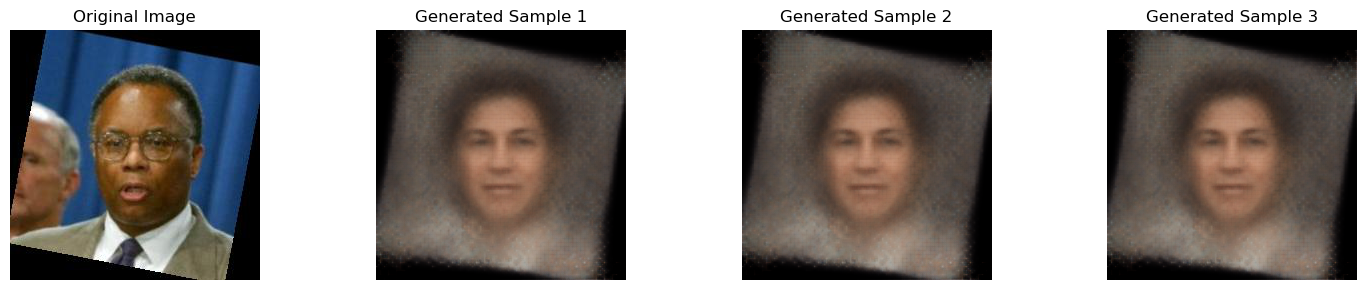

In [106]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set the device to MPS if available, else CPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Ensure your VAE model is on the correct device
conv_vae.to(device)

# Assuming conv_vae is your VAE model and dataloader is your DataLoader
# Function to generate distinct samples for a given image using the VAE
def generate_distinct_samples(vae_model, image, num_samples=3):
    vae_model.eval()  # Set the VAE to evaluation mode
    generated_images = []
    with torch.no_grad():
        image = image.to(device)
        # Encode the image to retrieve the mean and log variance
        mu, logvar = vae_model.encode(image.unsqueeze(0))
        for _ in range(num_samples):
            # Sample from the distribution having the calculated mean and log variance
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mu)
            # Decode the sampled latent vector to an image
            generated_image = vae_model.decode(z)
            generated_images.append(generated_image)
    return generated_images

# Select a random image from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0]  # Take the first image from the batch

# Generate distinct samples for the selected image
generated_images = generate_distinct_samples(conv_vae, random_image, num_samples=3)

# Move images to CPU for plotting if they are not already
original_image = random_image.to('cpu').permute(1, 2, 0).numpy()
generated_images_cpu = [img.squeeze().to('cpu').permute(1, 2, 0).numpy() for img in generated_images]

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# Plot the original image
axes[0].imshow(original_image, interpolation='nearest')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot each generated image
for i, gen_image in enumerate(generated_images_cpu):
    axes[i+1].imshow(gen_image, interpolation='nearest')
    axes[i+1].set_title(f"Generated Sample {i+1}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


To generate different images for different random images from your dataset, you need to ensure that for each image, you:

Encode the image to obtain its latent variables (mean and log variance).

Sample different points in the latent space using the reparameterization trick.

Decode these points back to image space to generate new images.